## EDA NOTEBOOK

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings("ignore")

np.random.seed(123)

In [3]:
rating_df = pd.read_csv('rating.csv')

### EXPLORATORY DATA ANALYSIS

In [4]:
#Print first 5 rows
rating_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [5]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [6]:
#Convert timestamp dtype to datetime
rating_df['timestamp'] = pd.to_datetime(rating_df['timestamp'])

In [7]:
#Print summary of some statistics
rating_df.describe()

,userId,movieId,rating,timestamp
count,2.000026e+07,2.000026e+07,2.000026e+07,20000263
mean,6.904587e+04,9.041567e+03,3.525529e+00,2004-11-20 02:32:01.677113984
min,1.000000e+00,1.000000e+00,5.000000e-01,1995-01-09 11:46:44
25%,3.439500e+04,9.020000e+02,3.000000e+00,2000-08-20 18:55:45
50%,6.914100e+04,2.167000e+03,3.500000e+00,2004-12-20 15:18:06
75%,1.036370e+05,4.770000e+03,4.000000e+00,2008-11-02 16:11:57.500000
max,1.384930e+05,1.312620e+05,5.000000e+00,2015-03-31 06:40:02
std,4.003863e+04,1.978948e+04,1.051989e+00,NaN


In [8]:
#Check for missing values
rating_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [9]:
#Randomly selecting 40% of user data, to reduce computational load and for quicker iteration
random_userIds = np.random.choice(rating_df['userId'].unique(), size = int(len(rating_df['userId'].unique())*0.4), replace = False)

In [10]:
#Querying for collecting random 40% user data.
rating_df = rating_df.loc[rating_df['userId'].isin(random_userIds)]

print('Current shape: {} rows of data from {} users'.format(len(rating_df), len(random_userIds)))

Current shape: 8022066 rows of data from 55397 users


In [11]:
#Check randomness
rating_df.sample(5)

,userId,movieId,rating,timestamp
10722146,74142,55805,1.0,2008-01-18 00:31:21
18881831,130729,2605,3.0,1999-12-22 10:58:06
630415,4222,1253,4.5,2012-09-24 00:27:40
8166367,56271,47,4.5,2007-06-09 02:25:02
6999461,48241,308,5.0,2001-10-24 21:24:03


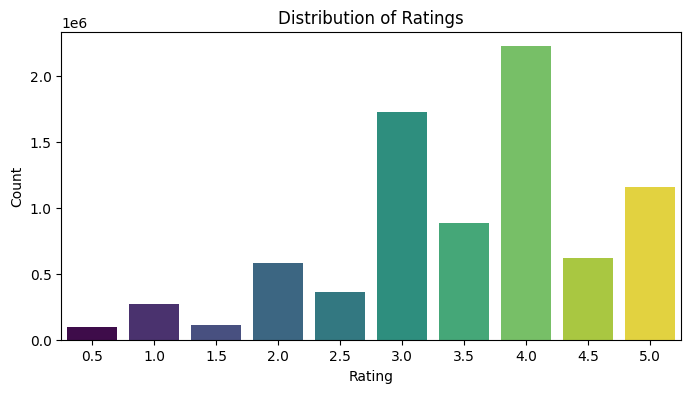

In [12]:
# Plot the distribution of ratings
plt.figure(figsize=(8, 4))
sns.countplot(data = rating_df, x = 'rating', hue = 'rating', legend = False, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [13]:
# Top 5 most rated movie Ids
ratings_per_movie = rating_df.groupby('movieId').size().reset_index(name='rating_count')

# Sort the movies by the number of ratings in descending order
sorted_ratings_per_movie = ratings_per_movie.sort_values(by='rating_count', ascending=False)

# Select the top 5 most rated movies
top_5_most_rated = sorted_ratings_per_movie.head(5)

top_5_most_rated

,movieId,rating_count
293,296,26902
352,356,26552
315,318,25342
587,593,25291
476,480,23932


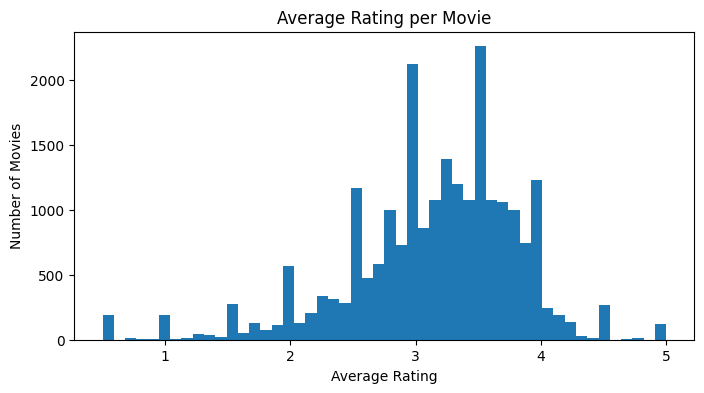

In [14]:
# Average Rating per Movie
average_rating_per_movie = rating_df.groupby('movieId')['rating'].mean()
plt.figure(figsize=(8, 4))
plt.hist(average_rating_per_movie, bins=50)
plt.title('Average Rating per Movie')
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.show()

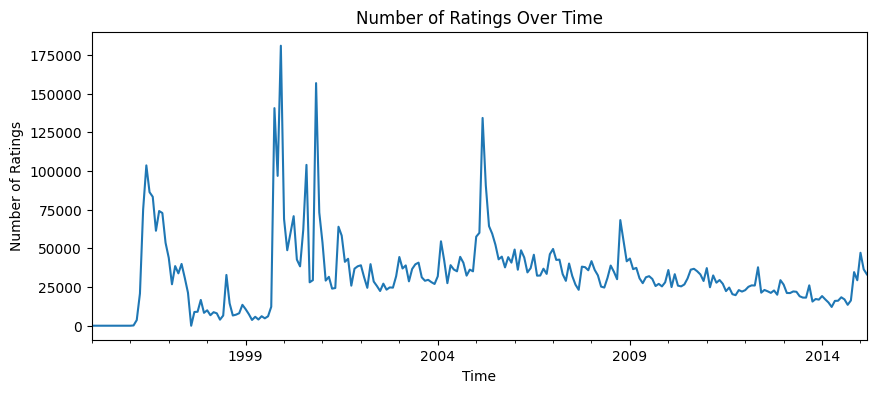

In [15]:
# Convert the timestamp to datetime
rating_df['timestamp'] = pd.to_datetime(rating_df['timestamp'], unit='s')

# Plot the number of ratings over time
ratings_over_time = rating_df.set_index('timestamp').resample('ME').size()

plt.figure(figsize=(10, 4))
ratings_over_time.plot()
plt.title('Number of Ratings Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Ratings')
plt.show()

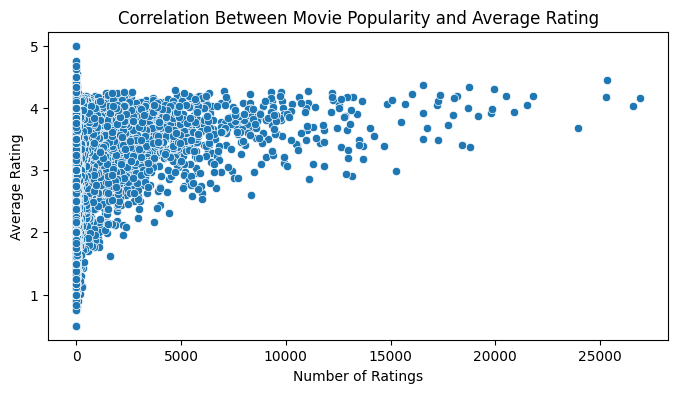

In [16]:
# Merge the number of ratings and average rating
movie_stats = rating_df.groupby('movieId')['rating'].agg(['mean', 'count'])

# Plot the correlation
plt.figure(figsize=(8, 4))
sns.scatterplot(x='count', y='mean', data=movie_stats)
plt.title('Correlation Between Movie Popularity and Average Rating')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.show()

In [17]:
print(f"Mean global rating: {round(rating_df['rating'].mean(),2)}.")

mean_ratings = rating_df.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.52.
Mean rating per user: 3.63.


## Exploring Data Sparsity

In [19]:
def create_X(df):
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(rating_df)

In [20]:
X.shape

(55397, 23027)

In [23]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 0.63%


In [30]:
n_ratings_per_user = X.getnnz(axis=1)
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 7515 movies.
Least active user rated 20 movies.


In [29]:
n_ratings_per_movie = X.getnnz(axis=0)
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 26902 ratings.
Least rated movie has 1 ratings.


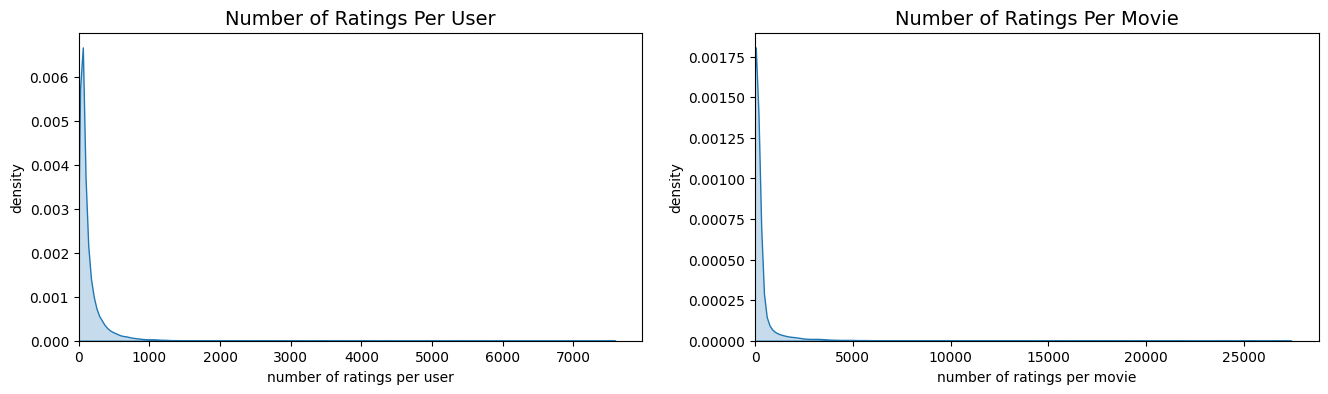

In [42]:
#most users provided very few ratings 
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")

#most movies received very few ratings
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

#Long-tail distribution

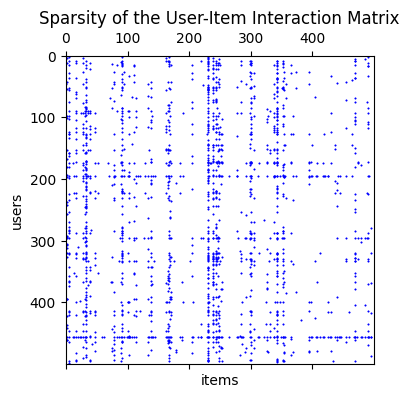

In [44]:
# Select a random subset of users and items to visualize sparsity
sample_users = random.sample(range(X.shape[0]), min(500, X.shape[0]))
sample_items = random.sample(range(X.shape[1]), min(500, X.shape[1]))

# Create the sample matrix
X_sample = X[sample_users, :][:, sample_items].todense()

# Plot the sparsity pattern of the sample
plt.figure(figsize=(4, 4))
plt.spy(X_sample, markersize=0.5, color='blue')
plt.title('Sparsity of the User-Item Interaction Matrix')
plt.xlabel('items')
plt.ylabel('users')
plt.show()